In [2]:
import wfdb
import numpy as np
import scipy as spy
import matplotlib.pyplot as plt

pat_id = 101

# Read a record from the database
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')

In [3]:
# Read record numbers
with open('./data/mitdb/RECORDS') as f:
    records = f.readlines()

for i in range(0,len(records)):
    records[i] = int(records[i])
    

In [4]:
# Read annotations
annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
loc = annotation.sample
beat_type = annotation.symbol
signal = record.p_signal[:,0]
set(beat_type)


{'+', 'A', 'N', 'Q', '|', '~'}

In [5]:
# Find RR-intervals for all records
# Check abnormally long/short intervals
rr_intervals = []
check = [] 
check_low = []

for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    location = annotation.sample
    for i in range(2, len(location)):
        if location[i]-location[i-1] > 1270:
            check.append(id)
        if location[i]-location[i-1] < 25:
            check_low.append(id)
        rr_intervals.append(location[i]-location[i-1])

(array([2.9400e+02, 1.8590e+03, 4.6440e+03, 1.5964e+04, 3.2821e+04,
        3.0903e+04, 1.4871e+04, 7.0300e+03, 2.9980e+03, 6.8800e+02,
        1.3700e+02, 6.6000e+01, 1.0900e+02, 5.6000e+01, 1.2000e+01,
        8.0000e+00, 1.0000e+01, 1.8000e+01, 2.2000e+01, 6.0000e+00,
        6.0000e+00, 9.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   6. ,   58.7,  111.4,  164.1,  216.8,  269.5,  322.2,  374.9,
         427.6,  480.3,  533. ,  585.7,  638.4,  691.1,  743.8,  796.5,
         849.2,  901.9,  954.6, 1007.3, 1060. , 1112.7, 1165.4, 1218.1,
        1270.8, 1323.5, 1376.2, 1428.9, 1481.6, 1534.3, 1587. , 1639.7,
        1692.4, 1745.1, 1797.8, 1850.5, 1903.2, 1955.9, 2008.6, 2061.3,
        2114. ]),
 <BarContainer object of 40 artists>)

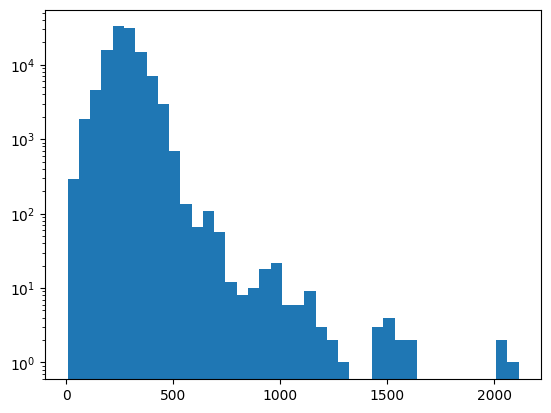

In [6]:
# Plot distribution of RR-intervals
plt.hist(rr_intervals, bins=40, log=True)

In [7]:
# Segment by using relative minimum RR-interval
segments = []
beat_types = []

classes = {0:'N',1:'S',2:'V',3:'F',4:'Q'}
reduced = {'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}

valid_types = ['N','L','R','e','j','S','A','a','J','V','E','F','/','Q','f']

reverse_reduced = {value: key for key, values in reduced.items() for value in values}

2072


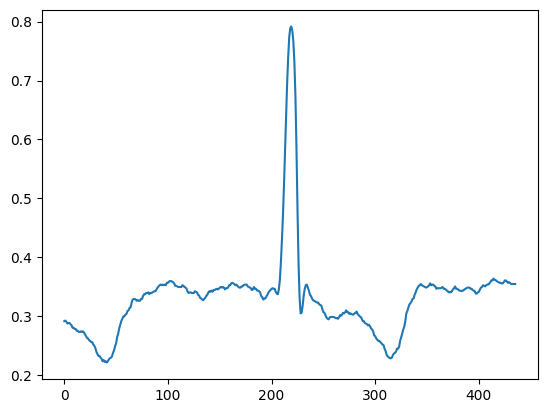

In [8]:
from pace.db import normalize_signal
#for id in records:
pat_id = 219 #219
annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
loc = annotation.sample
beat_type = annotation.symbol
signal = record.p_signal[:,0]

signal = normalize_signal(signal)

for i in range(2, len(loc)-1):
    if beat_type[i] not in valid_types:
        continue
    
    dist = round(min(loc[i]-loc[i-1], loc[i+1]-loc[i])*0.8)
    if dist * 2 < 100 or dist * 2 > 1000:
        continue

    segments.append(signal[loc[i]-dist:loc[i]+dist])
    beat_types.append(reverse_reduced[beat_type[i]])

print(len(segments))
plt.plot(segments[1])


660
23
N
N
N


(array([ 38.,  17.,   0.,   0.,   4.,   0.,   2.,   9.,   3.,   4.,   2.,
          4.,   2.,   6.,  12.,  66., 124., 168., 149., 134., 128., 128.,
        139., 141., 157., 154., 158., 123.,  81.,  51.,  35.,  12.,   5.,
          8.,   2.,   2.,   1.,   1.,   0.,   2.]),
 array([100., 114., 128., 142., 156., 170., 184., 198., 212., 226., 240.,
        254., 268., 282., 296., 310., 324., 338., 352., 366., 380., 394.,
        408., 422., 436., 450., 464., 478., 492., 506., 520., 534., 548.,
        562., 576., 590., 604., 618., 632., 646., 660.]),
 <BarContainer object of 40 artists>)

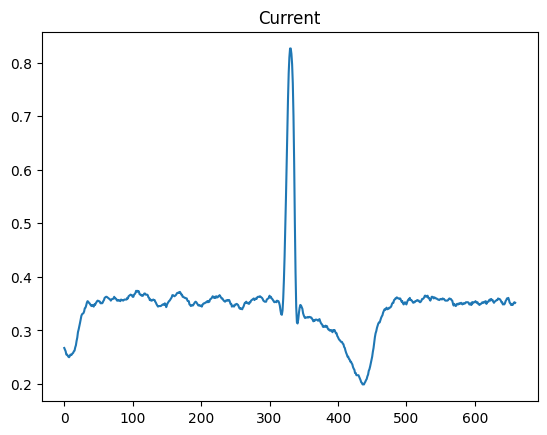

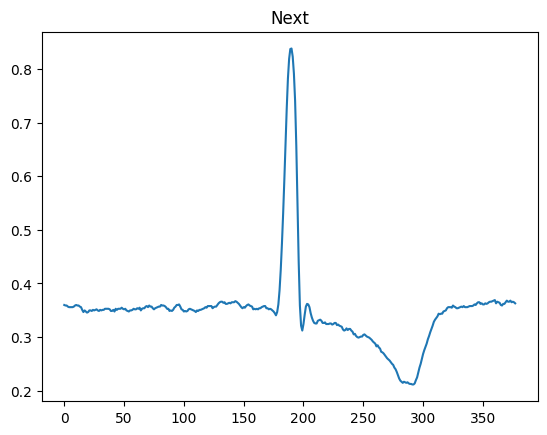

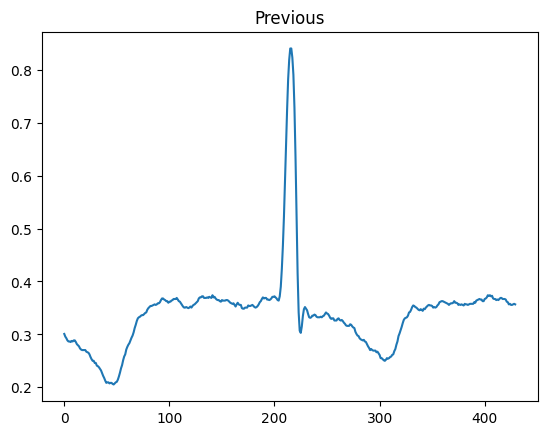

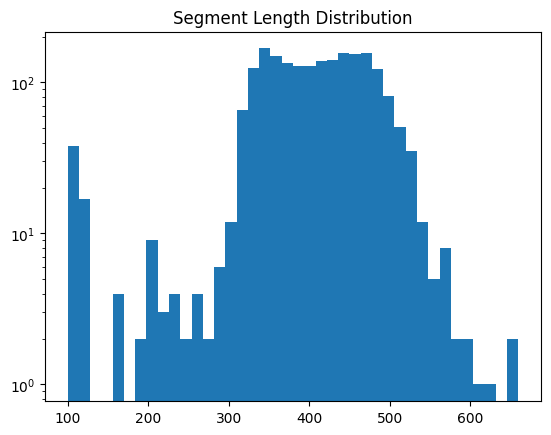

In [9]:
# Find min and max segment lengths
lengths = []
for segment in segments:
    lengths.append(len(segment))

# value = min(lengths)
value = max(lengths)
index = lengths.index(value)

print(value)
print(index-1)
print(beat_types[index])
print(beat_types[index+1])
print(beat_types[index-1])
plt.figure()
plt.title('Current')
plt.plot(segments[index])
plt.figure()
plt.title('Next')
plt.plot(segments[index+1])
plt.figure()
plt.title('Previous')
plt.plot(segments[index-1])

plt.figure()
plt.title('Segment Length Distribution')
plt.hist(lengths, bins=40, log=True)


In [10]:
# Toggle on/off
# Pre-CWT right side zero padding
# max_len = len(segments[0])

# for segment in segments:
#     max_len = max(len(segment), max_len)

# for i in range(0, len(segments)):
#     arr = np.zeros(max_len - len(segments[i]))
#     segments[i] = np.concatenate((segments[i], arr))

In [11]:
# arrhyth= []
# type = []
# for i in range(0, len(segments)):
#     if beat_types[i] != 'N':
#         arrhyth.append(i)
#         type.append(beat_types[i])
#         plt.figure()
#         plt.title(beat_types[i])
#         plt.plot(segments[i])
# print(arrhyth)
# print(type)

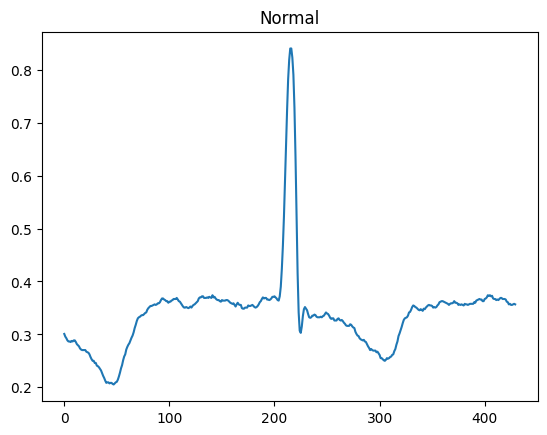

In [12]:
ID_TO_AAMI = {'N':'Normal', 'S':'Supraventricular premature', 'V':'Premature ventricular contraction', 'F':'Fusion of ventricular & normal', 'Q':'Unclassifiable'}
ID = 23  # 23, N

plt.title(ID_TO_AAMI[beat_types[ID]])
plt.plot(segments[ID])

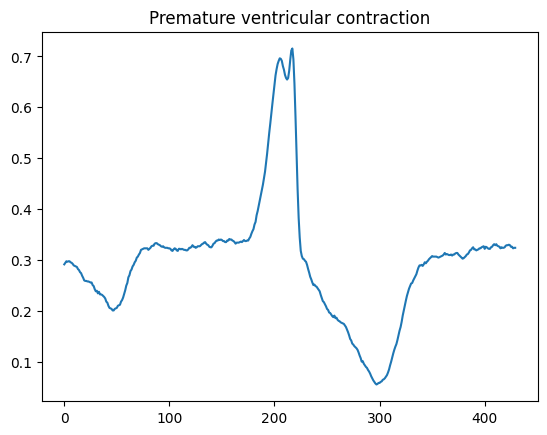

In [13]:
ID = 118 # 118, V

plt.title(ID_TO_AAMI[beat_types[ID]])
plt.plot(segments[ID])

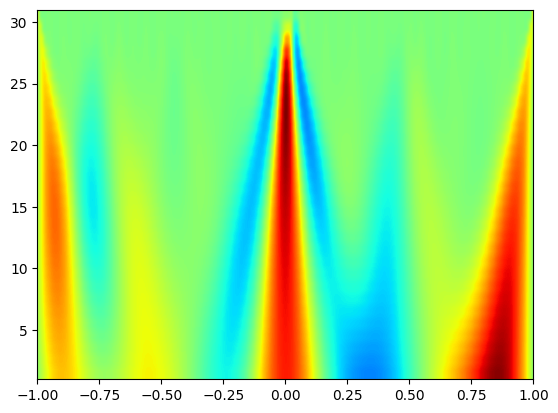

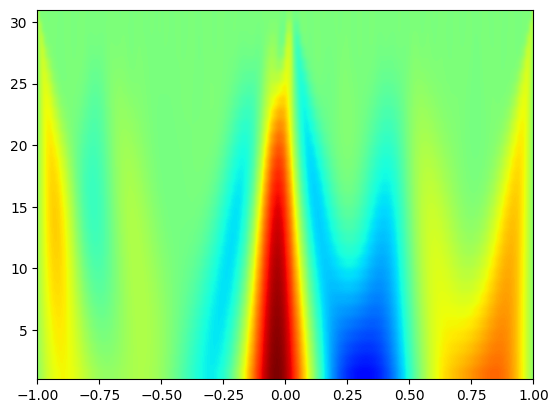

In [14]:
# Plot single continuous wavelet transform
widths = np.arange(1, 31)
colormap = 'jet'
ID = 23
cwtmatr = spy.signal.cwt(segments[ID], spy.signal.ricker, widths)
plt.figure()
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap=colormap, aspect='auto',
        vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

ID = 118
cwtmatr = spy.signal.cwt(segments[ID], spy.signal.ricker, widths)
plt.figure()
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap=colormap, aspect='auto',
        vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

In [15]:

# for i in range[(0, 1)]:
#     if beat_types[i] == 'N':
#         plt.figure()
#         plt.title(beat_types[i])
#         plt.plot(segments[i])
#         i+=100
# # print(arrhyth)
# print(type)

In [16]:
# for i in range(0, 10):
cwtmatr = spy.signal.cwt(segments[0], spy.signal.ricker, widths)

In [17]:
padding = ((0,0), (0,value-cwtmatr.shape[1]))
padded_matrix = np.pad(cwtmatr, pad_width=padding, mode='constant', constant_values=0)
padded_matrix

array([[-3.77937022e-04,  1.25811713e-01,  4.87748103e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02770661e-04,  1.22634447e-01,  1.67716147e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.05340476e-03,  1.06334299e-01,  1.78362573e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.78570709e-01, -2.34885947e-01, -1.90551623e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.80913081e-01, -2.37525141e-01, -1.93517612e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.82989700e-01, -2.39899216e-01, -1.96217372e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [18]:
from pace.db import get_bandpass_filter_signal, normalize_signal
segments = []
beat_types = []
for id in records:
    pat_id = id
    annotation = wfdb.rdann(f'./data/mitdb/{pat_id}', 'atr')
    record = wfdb.rdrecord(f'./data/mitdb/{pat_id}')
    loc = annotation.sample
    beat_type = annotation.symbol
    signal = get_bandpass_filter_signal(record=record)
    signal = normalize_signal(signal=signal)

    for i in range(2, len(loc)-1):
        if beat_type[i] not in valid_types:
            continue
        
        dist = round(min(loc[i]-loc[i-1], loc[i+1]-loc[i])*0.8)
        if dist * 2 < 100 or dist * 2 > 1000:
            continue

        segments.append(signal[loc[i]-dist:loc[i]+dist])
        beat_types.append(reverse_reduced[beat_type[i]])

print(len(segments))

109066


{'N': 90269, 'S': 2763, 'V': 7208, 'F': 802, 'Q': 8024}


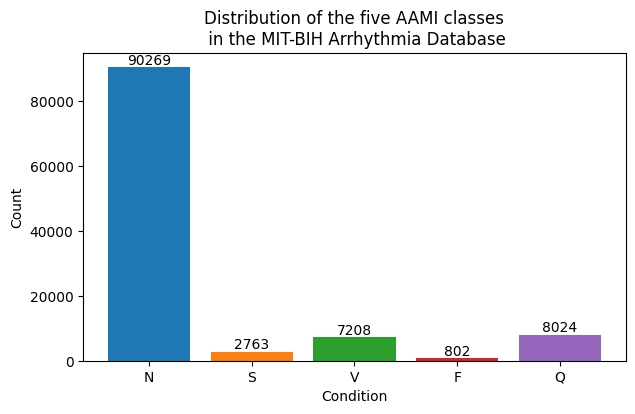

In [39]:
count = {'N':0,'S':0,'V':0,'F':0,'Q':0}
for beat in beat_types:
    count[beat] +=1

print(count)
types = list(count.keys())
values = list(count.values())

plt.figure(figsize=(7,4))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bars = plt.bar(types, values, color=colors[:len(values)])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height}', ha='center', va='bottom')

plt.title('Distribution of the five AAMI classes\n in the MIT-BIH Arrhythmia Database')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

In [20]:
# Classify each index of segments into its respective type
id_split = {'N':[],'S':[],'V':[],'F':[],'Q':[]}

for i in range(len(beat_types)):
    id_split[beat_types[i]].append(i)

In [21]:
len(id_split['N'])

90269

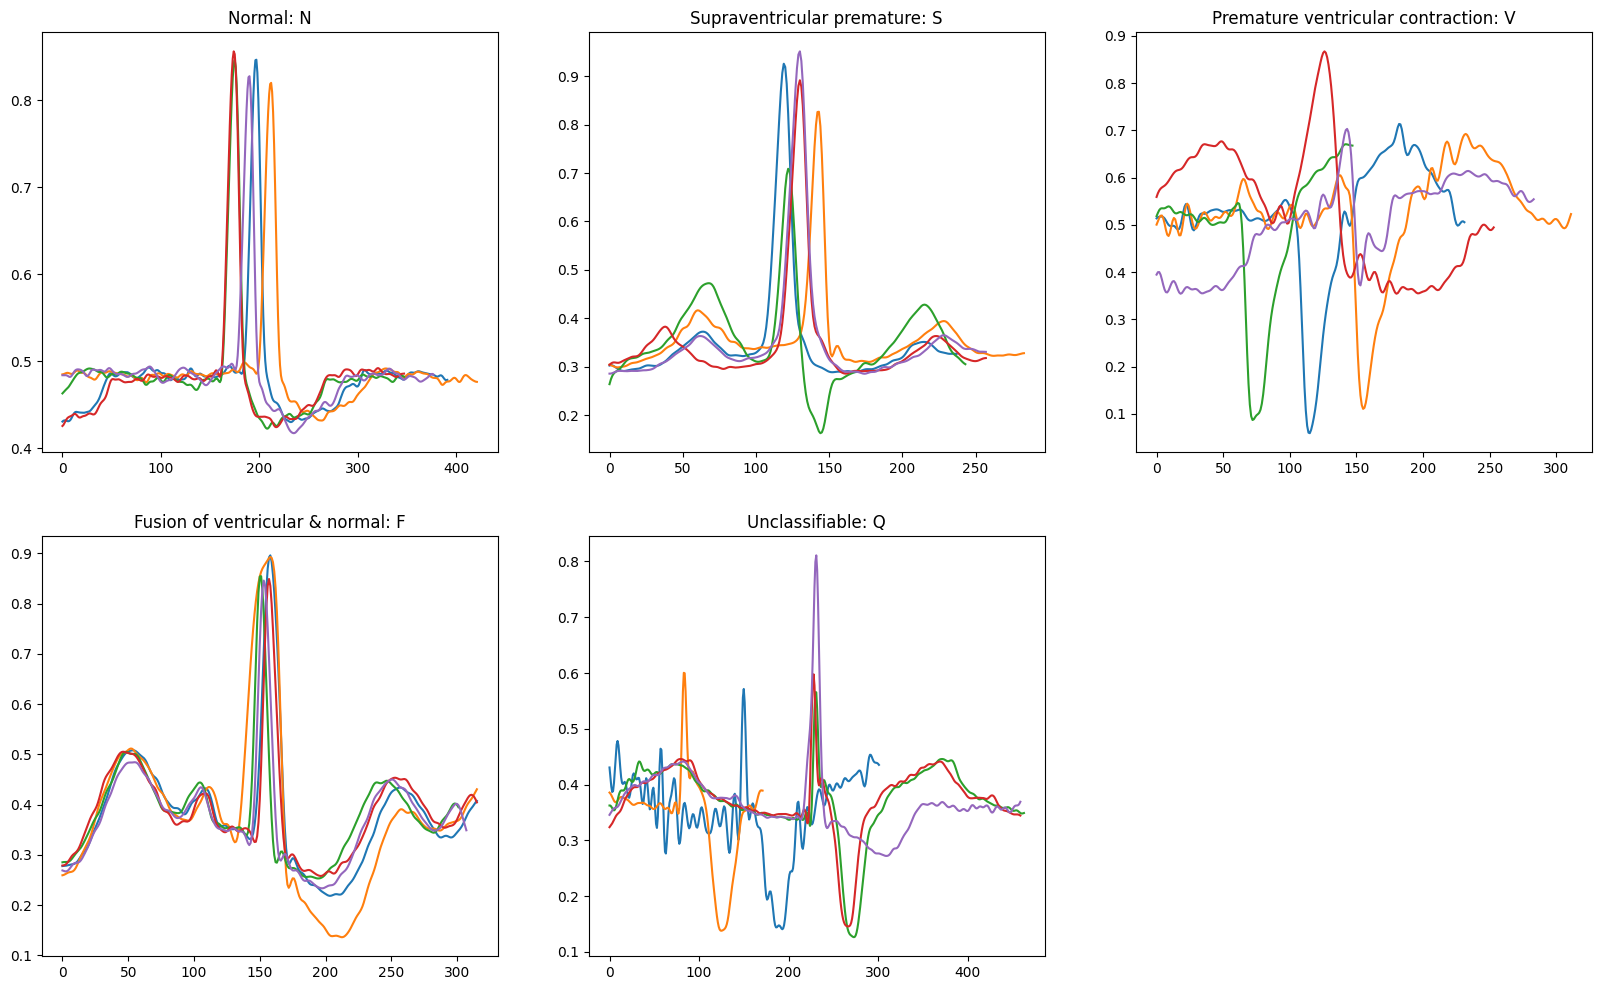

In [32]:
# Plot beats of the same AAMI class

ID_TO_AAMI = {0:'Normal', 1:'Supraventricular premature', 2:'Premature ventricular contraction', 3:'Fusion of ventricular & normal', 4:'Unclassifiable'}
ID_TO_BEAT = {0:['N','L','R','e','j'], 1:['S','A','a','J'], 2:['V','E'], 3:['F'], 4:['/','Q','f']}
classes = {0:'N',1:'S',2:'V',3:'F',4:'Q'}
num_beats = 5

plt.figure(figsize=(20,12))
for c in range(len(classes)):
    samples = id_split[classes[c]]
    rand = np.random.choice(range(num_beats, len(samples)-num_beats))
    samples = samples[0+rand:num_beats+rand]

    plt.subplot(2,3,c+1)
    plt.title(ID_TO_AAMI[c]+': '+classes[c])
    for samp in samples:
        plt.plot(segments[samp])
        
    

In [23]:
num_samples = 2763
samples = []
for id in id_split:
    if len(id_split[id]) < num_samples:
        id_split[id] = id_split[id] * int(np.ceil(num_samples/len(id_split[id])))
        
    samp = np.random.choice(id_split[id], num_samples, replace=False)
    samples.extend(samp)

len(samples)

13815

In [24]:
beats_samp = []
beat_IDs_samp = []
for i in samples:
    beats_samp.append(segments[i])
    beat_IDs_samp.append(beat_types[i])

print(len(beat_IDs_samp))

13815


In [25]:
data = [1,2,3,4]
data = np.array(data)
indices = np.random.permutation(len(data))

data = data[indices]

data

array([3, 2, 4, 1])

In [26]:
np.array(segments)[samples].tolist()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (109066,) + inhomogeneous part.